# 获取数据

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [2]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [3]:
X.shape

(70000, 784)

In [4]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [5]:
y.shape

(70000,)

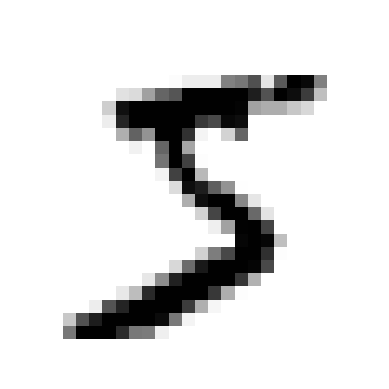

In [6]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [7]:
y[0]

'5'

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 训练二元分类器

先简化问题，只尝试识别一个数字。例如检测是否是数字'5'

In [9]:
y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

## 随机梯度下降

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

使用它来进行预测

In [20]:
sgd_clf.predict([some_digit])

array([ True])

# 性能指标

## 使用交叉验证测量准确率

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

准确率都超过了95%，让我们看一个DummyClassifier

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [13]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

仍然超过90%。这仅仅是因为大约 10％的图像是 5，所以如果您总是猜测一幅图像不是 5，您将有 90％的准确率。

分类器的首选性能指标不是**准确率**，而是**混淆矩阵**


## 混淆矩阵

混淆矩阵的一般思想是计算类 A 的实例被分类为类 B 的次数，对于所有 A/B 对。例如，要知道分类器将 8 的图像误判为 0 的次数，您将查看混淆矩阵的第 8 行，第 0 列。

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5  
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

![](./images/mls3_0303.png)

## 精度和召回率

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

现在我们的 `5` 检测器看起来并不像我们在查看其准确性时那么出色。当它声称一幅图像代表 `5` 时，它只有 83.7%的时间是正确的。此外，它只能检测到 65.1%的 `5`。

通常方便将精度和召回率结合成一个称为F<sub>1</sub> 分数的单一指标。F<sub>1</sub>是精度和召回率的调和平均数。调和平均值更加重视低值。因此，只有当召回率和精度都很高时，分类器才会获得高的F<sub>1</sub>分数。

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

某些起情况下你可能更关心精度/召回率，其中之一。
你不能两全其美：提高精度会降低召回率，反之亦然。这被称为精度/召回率权衡。

图像按其分类器得分排名，高于所选决策阈值的图像被视为正例；阈值越高，召回率越低，但（一般而言）精度越高

## 精度/召回率权衡

SGDClassifier是如何做出分类决策: 。对于每个实例，它根据决策函数计算得分。如果该得分大于阈值，则将实例分配给正类；否则将其分配给负类。

* 降低阈值会增加召回率并降低精度。
* 增加阈值会降低召回率并提高精度。

![](./images/mls3_0304.png)

Scikit-Learn 不允许直接设置阈值。可以调用分类器的decision_function()方法，返回每个实例的得分。

In [21]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier使用阈值等于 0

In [24]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

可以看出提高阈值会降低召回率。

如何决定使用哪个阈值？首先，使用cross_val_predict()函数获取训练集中所有实例的分数，但是这次指定要返回决策分数而不是预测：

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

使用这些分数，使用precision_recall_curve()函数计算所有可能阈值的精度和召回率（该函数添加最后一个精度为 0 和最后一个召回率为 1，对应于无限阈值）

In [30]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

使用 Matplotlib 绘制精度和召回率作为阈值值的函数

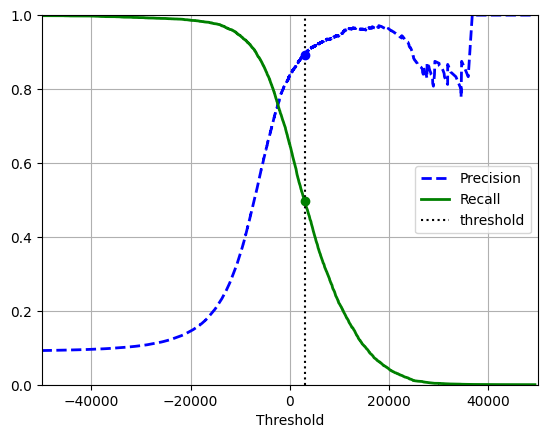

In [46]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

为什么精度曲线比召回率曲线更加崎岖？

答：当你提高阈值时，精度有时会下降（尽管通常会上升）。当你从中心阈值开始，将其向右移动一个数字时会发生什么：精度从 4/5（80%）下降到 3/4（75%）。

另一方面，当增加阈值时，召回率只能下降，这解释了为什么其曲线看起来平滑。

![](./images/mls3_0304.png)

选择一个良好的精度/召回率折衷的另一种方法是直接绘制精度与召回率的图表

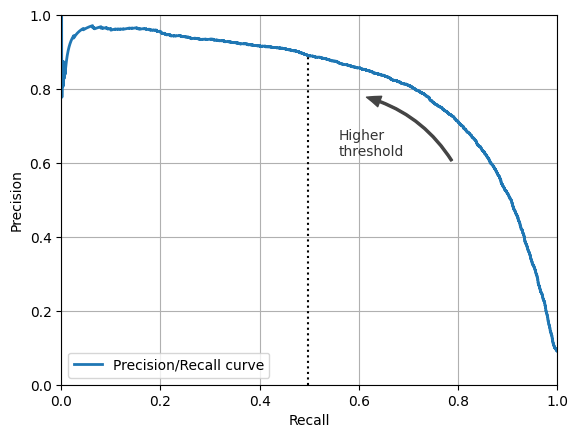

In [58]:
import matplotlib.patches as patches

plt.plot(recalls, precesions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

你可以看到精度在约 80%的召回率处开始急剧下降。你可能希望在该下降之前选择一个精度/召回率折衷，例如在约 60%的召回率处。但是，选择取决于你的项目。

假设你决定追求 90%的精度。你可以使用第一个图表找到需要使用的阈值，但这不太精确。或者，你可以搜索给出至少 90%精度的最低阈值。为此，你可以使用 NumPy 数组的argmax()方法。这将返回最大值的第一个索引，这在这种情况下意味着第一个True值：

In [60]:
idx_for_90_precision = (precisions >=0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

要进行预测（目前只是在训练集上），而不是调用分类器的predict()方法，你可以运行这段代码

In [61]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

检查这些预测的精度和召回率：

In [62]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [63]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC 曲线

ROC 曲线是与二元分类器一起使用的另一个常见工具。它与精度/召回率曲线非常相似，但是 ROC 曲线不是绘制精度与召回率，而是绘制真正例率（召回率的另一个名称）与假正例率（FPR）。FPR（也称为误报率）是被错误分类为正例的负实例的比率。它等于 1 减去真负例率（TNR），即被正确分类为负例的负实例的比率。TNR 也称为特异性。因此，ROC 曲线绘制灵敏度（召回率）与 1-特异性。

使用`roc_curve()`函数计算各种阈值的 TPR 和 FPR：

In [64]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

可以使用 Matplotlib 绘制 FPR 与 TPR。由于在这种情况下，阈值按降序列出，因此我们在第一行上使用`<=`而不是`>=`：

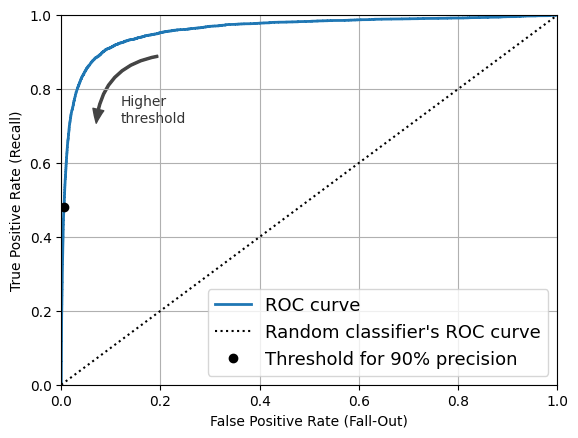

In [71]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
plt.show()

召回率（TPR）越高，分类器产生的假阳性（FPR）就越多。虚线代表纯随机分类器的 ROC 曲线；一个好的分类器尽可能远离该线（朝向左上角）